# Simple discrete simulation: Dahlin controller

This notebook replicates Figure 17.11 in Seborg et al without using analytic methods. If you want to get some insight into the math behind the z transform, applied to the same problem see the [Dahlin controller](Dahlin%20controller) notebook.

In [1]:
import tbcontrol

In [2]:
tbcontrol.expectversion('0.2.1')

In [3]:
from tbcontrol import blocksim

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import numpy
import control

## Simple discretisation

The control module supplies an easy access point to a transfer function which represents s.

In [6]:
s = control.TransferFunction.s

In [7]:
K = 1
τ1 = 5
τ2 = 3
θ = 0

In [8]:
Δt = 1

In [9]:
assert θ % Δt == 0  # this is only correct when the delay is a multiple of the sampling time
N = int(θ/Δt)

In [10]:
G = K/((τ1*s + 1)*(τ2*s + 1))

Discretize G assuming a zero order hold in front of it, this corresponds to using Table 17.1

In [11]:
z = control.TransferFunction.z

In [12]:
Gz = G.sample(Δt)*z**(-N)
Gz


  0.02797 z + 0.02341
----------------------
z^2 - 1.535 z + 0.5866

dt = 1

## Do discrete transfer function math

Dahlin controller relationship

In [13]:
λ = Δt   # this is a tuning parameters

In [14]:
A = numpy.exp(-Δt/λ)
Gdc = 1/Gz * (1 - A)*z**(-N - 1) / (1 - A*z**-1 - (1 - A)*z**(-N - 1))  # eq 17.65

After these calculations Gdc is

In [15]:
Gdc


  0.6321 z^4 - 0.9705 z^3 + 0.3708 z^2
----------------------------------------
0.02797 z^4 - 0.004556 z^3 - 0.02341 z^2

dt = 1

Notice that there are "extra" orders of z above and below the line in that expression - we could simplify it. This is what `.minreal` does.

In [16]:
Gdc = Gdc.minreal()

In [17]:
Gdc


22.6 z^2 - 34.7 z + 13.26
-------------------------
 z^2 - 0.1629 z - 0.8371

dt = 1

Much better.

## Convert from positive to negative powers of z

We still have a problem, though, since the control library uses positive powers of $z$ rather than negative powers of $z$. `tbcontrol.conversion` contains some methods to help convert such polynomials. Also notice that the `.num` and `.den` properties of the control library's tf objects are designed for MIMO systems, so they are nested lists corresponding with the index of the output and the input we want. Since we're just looking at one input and one output, we need the first element of the first element (`[0][0]`).

In [18]:
import tbcontrol.conversion

In [19]:
Gdc_neg_num, Gdc_neg_den = tbcontrol.conversion.discrete_coeffs_pos_to_neg(Gdc.num[0][0], Gdc.den[0][0])

In [20]:
Gdc_neg_num

[22.59988127611586, -34.69674036625465, 13.258134912008916]

In [21]:
Gdc_neg_den

[1.0, -0.1628886995509321, -0.8371113004490679]

## Simple blocksim simulation

In [22]:
blocksim_G = blocksim.LTI('G', 'u', 'yu', G.num[0][0], G.den[0][0])

In [23]:
blocksim_Gdc = blocksim.DiscreteTF('Gc', 'e', 'u', 1, Gdc_neg_num, Gdc_neg_den)

In [24]:
diagram = blocksim.simple_control_diagram(blocksim_Gdc, blocksim_G, ysp=blocksim.step(starttime=5))

In [25]:
ts = numpy.arange(0, 20, 0.01)

In [26]:
result = diagram.simulate(ts)

In [27]:
def plot_outputs(result):
    fig, (ax_y, ax_u) = plt.subplots(1, 2, figsize=(15, 5))

    ax_y.plot(ts, result['ysp'])
    ax_y.plot(ts, result['y'])
    ax_y.set_ylim(0, 2)
    ax_y.set_ylabel('y')

    ax_u.plot(ts, result['u'])
    ax_u.set_ylim(-50, 50)
    ax_u.set_ylabel('u')

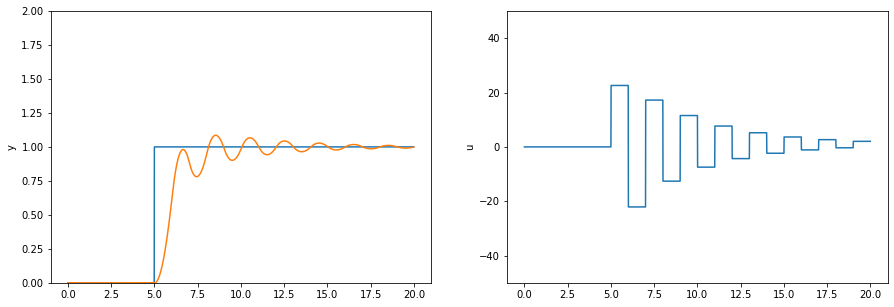

In [28]:
plot_outputs(result)